# Computation of the virtual orbitals and check of the completeness relation for $N_2$

We consider a $N_2$ molecule and we determine the maximum energy, that is the energy of the last virtual orbital in function of the number of virtual orbitals.

In [1]:
#%autosave 0
from BigDFT import Logfiles as lf
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
inputpath = 'input-virt/'

Autosave disabled


## Analysis for rmult =[7.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         #'output_denspot': 22, # save density on file
         'itermax_virt' : 1}, #stop the iterations
        'radical': 'N2_rmult7', #always in the same directory
        'output': {'orbitals': 2}, #write wfn on disk
        'posinp': 'N2_posinp.xyz'}

and we write these common variables in the default file:

In [3]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [4]:
norb=[16,32,64,128,256]

In [5]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inpname = 'N2_rmult7_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

In [2]:
from BigDFT import Calculators as C
code=C.SystemCalculator(omp=2,mpi=2)

In [8]:
%cd $inputpath
code.run(name='N2_rmult7_norb16',outdir='./log')
%cd ../

/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2/input-virt
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2_rmult7_norb16 -d ./log
/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2


In [ ]:
%cd $inputpath
code.run(name='N2_rmult7_norb32',outdir='./log')
%cd ../

/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2/input-virt
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2_rmult7_norb32 -d ./log


We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [6]:
logs = !ls $inputpath/log-N2_rmult7_*
print(logs)
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

['input-virt//log-N2_rmult7_norb128.yaml', 'input-virt//log-N2_rmult7_norb256.yaml', 'input-virt//log-N2_rmult7_norb256.yaml.yaml', 'input-virt//log-N2_rmult7_norb32.yaml', 'input-virt//log-N2_rmult7_norb64.yaml']


5

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [7]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[128, 256, 0, 32, 64]
[0.94563029961099698, 1.45462201557233, -0.38199635142119998, 0.39752071343558598, 0.53566688436341803]


and we sort their argument according the number ov virtual orbitals:

In [8]:
l = np.argsort(Norbv)
l

array([2, 3, 4, 0, 1])

In [9]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[0, 32, 64, 128, 256]
[-0.38199635142119998, 0.39752071343558598, 0.53566688436341803, 0.94563029961099698, 1.45462201557233]


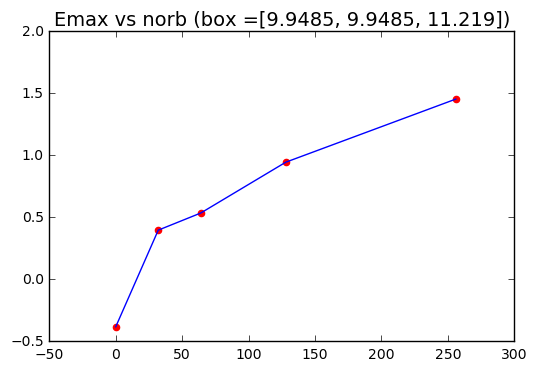

In [10]:
plt.plot(N,E)
plt.scatter(N,E, color='r')
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()

To check for the convergence of the orbitals we perform a run with the Davison algorithm

In [11]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 2},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

Yaml.dump(inp0,inputpath + 'default.yaml')

inp={'dft':{'norbv': 256, 'nvirt' : 256}}

inpname = 'N2_Davidson_rmult7_norb256'
Yaml.dump(inp,inputpath + inpname + '.yaml')

We see that the Davidson algorithm does not improve the convergence and we use the orbitals built with the former method.

### Expansion of the perturbed KS orbitals

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e-2$ both in the $z$ and $x$ directions. The orbitals of the perturbed system have been computed for rmult = [7.0 , 9.0]

In [11]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'gnrm_cv' :1e-8,
         'inputpsiid': 2, #restart from previous wfn
         #'output_wf': 2, #write wfn on disk
         'itermax_virt' : 1},#00},
        'radical': 'N2_rmult7', #always in the same directory
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,inputpath + 'default.yaml')

The path of the $psi'$ orbitals must be given in as a relative path starting from the folder that contains the log files. 
For the second run, the one with the $E_z$ perturbation in this case, we don't write the resulting wf on the disk and set itermax_virt : 1, in this way the simulation only perform the scalar product of the states given as input with the perturbed wf

In [25]:
n = 256
Ex_psip = '../input/log/data-Ex_1em2_rmult_7/'
Ez_psip = '../input/log/data-Ez_1em2_rmult_7/'
inpEx={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ex_psip}}
inpEz={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ez_psip}}
ExInpname = 'N2Ex_rmult7_norb'+str(n)
EzInpname = 'N2Ez_rmult7_norb'+str(n)

Yaml.dump(inpEz,inputpath + EzInpname + '.yaml')
Yaml.dump(inpEx,inputpath + ExInpname + '.yaml')

In [26]:
from BigDFT import Calculators as C
code=C.SystemCalculator(omp=2,mpi=2)
%cd 'input-virt/'
code.run(name=ExInpname)
code.run(name=EzInpname)
%cd ../

/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2/input-virt
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2Ex_rmult7_norb256
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2Ez_rmult7_norb256
/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2


Now we import the result and perform the data analysis

In [3]:
def completeness_relation(logs):
    data=[lf.Logfile(l) for l in logs]
    coeff_occ = [n.log['<psi_i|psi_j>'] for n in data]
    coeff_occ=np.double(np.array(coeff_occ))
    
    coeff_vrt = [n.log['<psiv_i|D psi_j>'] for n in data]
    coeff_vrt=np.double(np.array(coeff_vrt))
    
    n_occ,n_vrt = coeff_vrt[0].shape
    print 'no_occ',n_occ, 'n_vrt', n_vrt
    en = data[0].evals[0][0]
    e_v=[]
    e_o=[]
    for o in range(n_occ):
        e_o.append(en[o])
    for v in range(n_occ,n_occ+n_vrt):
        e_v.append(en[v])

    # we compute the norm of the perturbed orbitals projected on the basis of the occupied states
    psiprimeEx=np.array([ 0.0 for i in range(n_occ)])
    psiprimeEz=np.array([ 0.0 for i in range(n_occ)])
    for o in range(n_occ):
        psiprimeEx += coeff_occ[0][o]**2
        psiprimeEz += coeff_occ[1][o]**2
    # we quantify the magnitude of the missing part
    psiprimeEx = 1.0-psiprimeEx
    psiprimeEz = 1.0-psiprimeEz
    print 'psiprimeEx Norm ',np.sqrt(psiprimeEx)
    print 'psiprimeEz Norm ',np.sqrt(psiprimeEz)
    # and we find the maximum value
    referenceEx=np.max(psiprimeEx)
    referenceEz=np.max(psiprimeEz)
    # we add the contribution of the empty orbitals
    crEx=[[] for p in range(n_occ)]
    crEz=[[] for p in range(n_occ)]
    for p in range(n_occ):
        for v in range(n_vrt):
          psiprimeEx[p] -= coeff_vrt[0][p][v]**2
          psiprimeEz[p] -= coeff_vrt[1][p][v]**2    
          crEx[p].append(psiprimeEx[p]/referenceEx)
          crEz[p].append(psiprimeEz[p]/referenceEz)
    return e_v,crEx,crEz

In [4]:
def crplot(e_v,cr,label,avg=True):
    import numpy as np
    if avg:
        sm=0.0
        nval=0
        for coeff in cr:
            sm+=np.array(coeff)
            nval+=1
        plt.semilogy(27.211*np.array(e_v),sm/nval,'-',label='<CR>')
    else:
        for p,coeff in enumerate(cr):
            plt.semilogy(27.211*np.array(e_v),cr[p],'-',label='CR'+str(p))
    plt.legend()
    plt.title('Completeness relation'+label, fontsize=14)

In [7]:
logs = !ls input-virt/log-N2E*_rmult7_norb256.yaml
print(logs)
N2data=[lf.Logfile(l) for l in logs]

['input-virt/log-N2Ex_rmult7_norb256.yaml', 'input-virt/log-N2Ez_rmult7_norb256.yaml']


We define the  following list of arrays (the first element correponds to Ex, the second to Ez): 

In [4]:
coeff_occ = [n.log['<psi_i|psi_j>'] for n in N2data]
coeff_occ=np.double(np.array(coeff_occ))

coeff_vrt = [n.log['<psiv_i|D psi_j>'] for n in N2data]
coeff_vrt=np.double(np.array(coeff_vrt))

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

We also read other useful quantities (we define common quantities for both Ex and Ez since the orbitals are the same)

In [5]:
n_occ,n_vrt = coeff_vrt[0].shape
print 'no_occ',n_occ, 'n_vrt', n_vrt
en = N2data[0].evals[0][0]
e_v=[]
e_o=[]
for o in range(n_occ):
    e_o.append(en[o])
for v in range(n_occ,n_occ+n_vrt):
    e_v.append(en[v])


no_occ 5 n_vrt 256


In [6]:
# we compute the norm of the perturbed orbitals projected on the basis of the occupied states
psiprimeEx=np.array([ 0.0 for i in range(n_occ)])
psiprimeEz=np.array([ 0.0 for i in range(n_occ)])
for o in range(n_occ):
    psiprimeEx += coeff_occ[0][o]**2
    psiprimeEz += coeff_occ[1][o]**2
# we quantify the magnitude of the missing part
psiprimeEx = 1.0-psiprimeEx
psiprimeEz = 1.0-psiprimeEz
print 'psiprimeEx Norm ',np.sqrt(psiprimeEx)
print 'psiprimeEz Norm ',np.sqrt(psiprimeEz)
# and we find the maximum value
referenceEx=np.max(psiprimeEx)
referenceEz=np.max(psiprimeEz)
# we add the contribution of the empty orbitals
crEx=[[] for p in range(n_occ)]
crEz=[[] for p in range(n_occ)]
for p in range(n_occ):
    for v in range(n_vrt):
      psiprimeEx[p] -= coeff_vrt[0][p][v]**2
      psiprimeEz[p] -= coeff_vrt[1][p][v]**2    
      crEx[p].append(psiprimeEx[p]/referenceEx)
      crEz[p].append(psiprimeEz[p]/referenceEz)

psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]


In [39]:
#to display the plot in a separate window
#%matplotlib auto
#to display back in the nb
#%matplotlib inline 

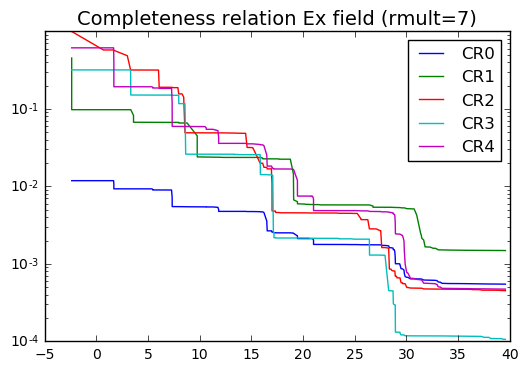

In [40]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEx[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ex field (rmult=7)', fontsize=14)
plt.show()

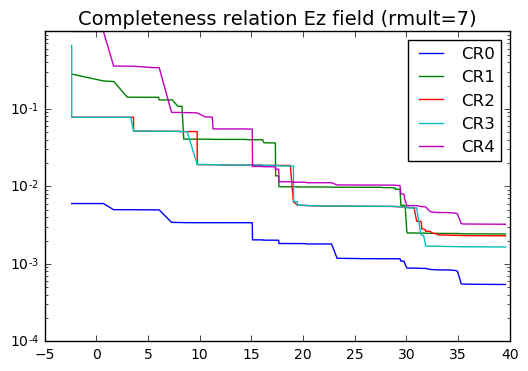

In [41]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEz[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ez field (rmult=7)', fontsize=14)
plt.show()

Test of the cr function

In [8]:
e_v,crEx,crEz=completeness_relation(logs)

no_occ 5 n_vrt 256
psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]


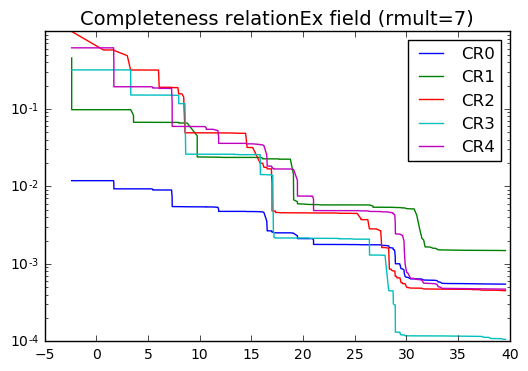

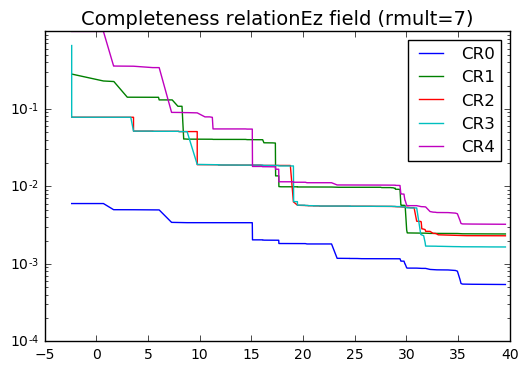

In [11]:
%matplotlib inline
crplot(e_v,crEx,'Ex field (rmult=7)',False)
plt.show()
crplot(e_v,crEz,'Ez field (rmult=7)',False)
plt.show()

# Creation of the empty states from O(N) computation
In this section of the notebook we will:

 * Create the states from a support function calculations
 * Orthogonalize the empty states created in this way with respect to the occupied states of the cubic computation
 * Use the basis generated in such a way to express the completeness relation
 
Let us first create the support functions in the O(N) scheme and write them as "virtual" states:

In [73]:
inputpath='input-virt-on/'
inputon=Yaml.load(stream="""
dft:
  hgrids: 0.4
  rmult: [7.0, 9.0]
  #elecfield: [0.0, 0.0, 0.01]
import: linear #perform a O(N) calculation
lin_general: 
  subspace_diag: Yes #calculate the KS orbital in the support function basis
  extra_states: 2
lin_basis_params: 
  N: 
    nbasis: 23 #put 16 DoF per atom
    rloc: 10.0 
    rloc_kernel_foe: 12.5
ig_occupation: #create a s-p-d-f basis as a initial guess
 N:
  2s: 2 #1 
  2p: 3 #3
  3d: 0 #5
  4f: 0 #7
  3s: 0 #1
  3p: 0 #3
  4p: 0 #3
posinp:
   units                               : angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
output:
  orbitals: text
  outputpsiid: virtuals
""")
inpname = 'N2_rmult7_on'
Yaml.dump(inputon,inputpath + inpname + '.yaml')

In [74]:
%cd $inputpath
code.run(name=inpname)
%cd ../

/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2/input-virt-on
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2_rmult7_on
/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2


In [75]:
inputcubic_restarted=Yaml.load(stream="""
dft:
  hgrids: 0.4
  rmult: [7.0, 9.0]
  gnrm_cv: 1.e-8
  inputpsiid: 2 #read functions
  itermax_virt: 1 #do not optimize them
  norbv: -46 #take the on orbitals
posinp:
   units                               : angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
output:
  orbitals: binary
radical: N2_rmult7_on
""")
inpname = 'N2_rmult7_restarted'
Yaml.dump(inputcubic_restarted,inputpath + inpname + '.yaml')

In [76]:
%cd $inputpath
code.run(name=inpname)
%cd ../

/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2/input-virt-on
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2_rmult7_restarted
/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2


Let us now inspect what is the modifications to the density of states that this orthogonalization implied

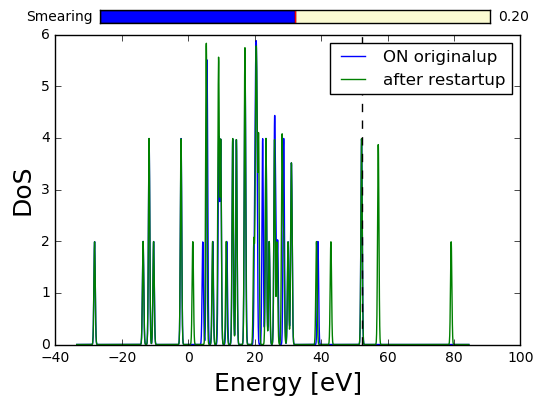

In [77]:
#%matplotlib auto
on_orig=lf.Logfile('input-virt-on/log-N2_rmult7_on.yaml',label='ON original')
on_ortho=lf.Logfile('input-virt-on/log-N2_rmult7_restarted.yaml')
dos=on_orig.get_dos()
dos.append_from_bandarray(on_ortho.evals,label='after restart')
dos.plot()

We can then compare the density of states of the 
 * Orthogonalized ON basis functions
 * The cubic code approach with 32 virtual states
 * The cubic approach with 256 states, considered as reference

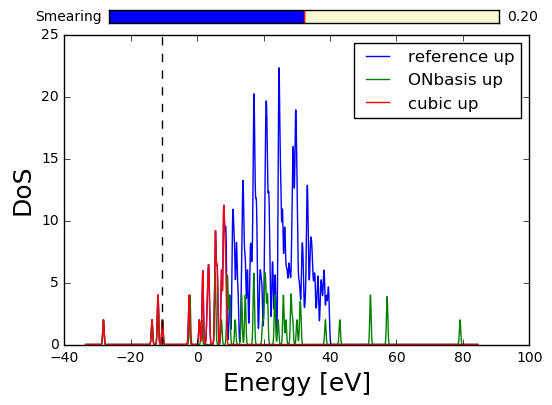

In [78]:
#%matplotlib auto
cubic_256=lf.Logfile('input-virt/log-N2_rmult7_norb256.yaml',label='reference ')
cubic_32=lf.Logfile('input-virt/log-N2_rmult7_norb32.yaml')
dos=cubic_256.get_dos()
dos.append_from_bandarray(on_ortho.evals,label='ONbasis ')
dos.append_from_bandarray(cubic_32.evals,label='cubic ')
dos.plot()

Here we can see that the basis set of the ON is somehow higher in energy. It is also interesting to notice that the peaks of the dos somehow coincide.
Let us now inspect the completeness relation in this basis.

In [79]:
from copy import deepcopy
Ex_psip = '../input/log/data-Ex_1em2_rmult_7/'
Ez_psip = '../input/log/data-Ez_1em2_rmult_7/'
inpEx=deepcopy(inputcubic_restarted)
inpEx['tddft']={'decompose_perturbation': Ex_psip}
inpEz=deepcopy(inputcubic_restarted)
inpEz['output']['orbitals']='binary'
inpEz['tddft']={'decompose_perturbation': Ez_psip}
inpnamex = 'N2_rmult7_restartedx_cr'
inpnamez = 'N2_rmult7_restartedz_cr'
Yaml.dump(inpEx,inputpath + inpnamex + '.yaml')
Yaml.dump(inpEz,inputpath + inpnamez + '.yaml')

In [80]:
from BigDFT import Calculators as C
%cd $inputpath
code.run(name=inpnamex)
code.run(name=inpnamez)
%cd ../

/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2/input-virt-on
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2_rmult7_restartedx_cr
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n N2_rmult7_restartedz_cr
/local/genovese/work/KPM/KPM-nb/STATIC ELECTRIC FIELD/N2


We can here evaluate the completeness relation with the new basis.

In [81]:
logs=!ls input-virt-on/log-N2_rmult7_restarted?_cr.yaml

In [82]:
e_v,crEx,crEz=completeness_relation(logs)

no_occ 5 n_vrt 46
psiprimeEx Norm  [ 0.00126604  0.01044642  0.01162027  0.00656226  0.00910909]
psiprimeEz Norm  [ 0.00111001  0.00759885  0.01160832  0.0116083   0.01431236]


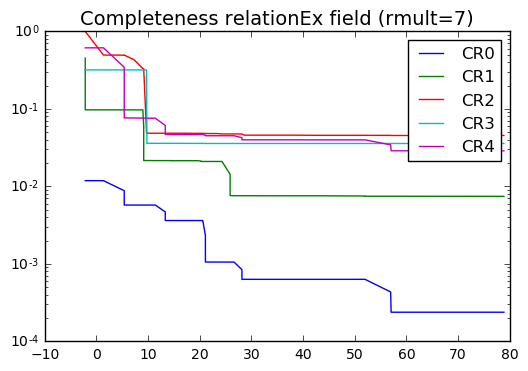

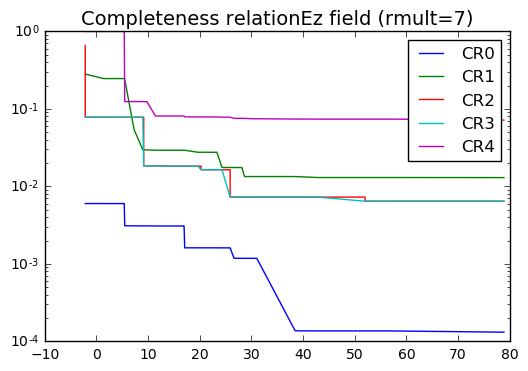

In [83]:
crplot(e_v,crEx,'Ex field (rmult=7)',False)
plt.show()
crplot(e_v,crEz,'Ez field (rmult=7)',False)
plt.show()

Let us now superimpose the plots:

In [84]:
logs_cubic = !ls input-virt/log-N2E*_rmult7_norb256.yaml
logs_on=!ls input-virt-on/log-N2_rmult7_restarted?_cr.yaml

In [85]:
e_v_c,crEx_c,crEz_c=completeness_relation(logs_cubic)
e_v_l,crEx_l,crEz_l=completeness_relation(logs_on)

no_occ 5 n_vrt 256
psiprimeEx Norm  [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]
psiprimeEz Norm  [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]
no_occ 5 n_vrt 46
psiprimeEx Norm  [ 0.00126604  0.01044642  0.01162027  0.00656226  0.00910909]
psiprimeEz Norm  [ 0.00111001  0.00759885  0.01160832  0.0116083   0.01431236]


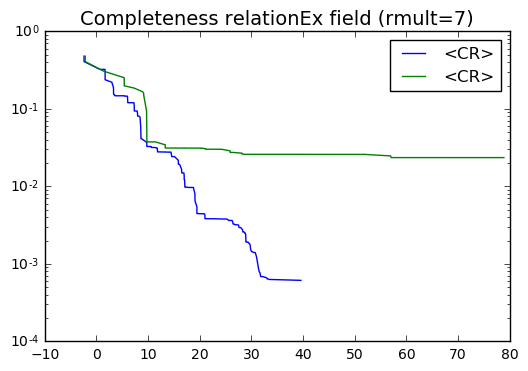

In [86]:
crplot(e_v_c,crEx_c,'Ex field (rmult=7)')
crplot(e_v_l,crEx_l,'Ex field (rmult=7)')
plt.show()

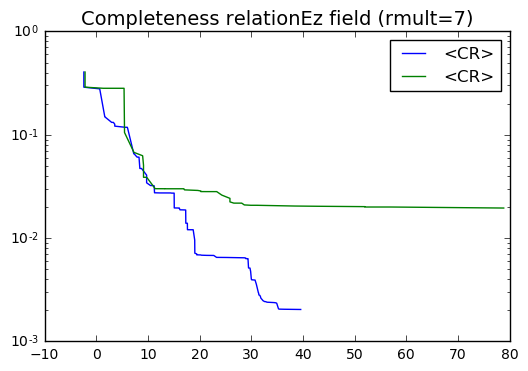

In [87]:
crplot(e_v_c,crEz_c,'Ez field (rmult=7)')
crplot(e_v_l,crEz_l,'Ez field (rmult=7)')
plt.show()

## Analysis for rmult =[9.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run

In [21]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [9.0, 9.0],
         'gnrm_cv' :1e-8,
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 100},
        'radical': 'N2_rmult9', #always in the same directory
        'posinp': 'N2_posinp.xyz'}

and we write these common variables in the default file:

In [22]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [23]:
norb=[16,32,64,128,256]

In [24]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inpname = 'N2_rmult9_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [25]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2_rmult9_*
print(logs)
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

['testfiles/N2maxEngVorb/log/log-N2_rmult9_norb128.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb16.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb256.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb32.yaml', 'testfiles/N2maxEngVorb/log/log-N2_rmult9_norb64.yaml']


5

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [26]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[128, 16, 256, 32, 64]
[0.65415558358574399, 0.18400946793181, 1.00658767681626, 0.27083912161076301, 0.39650250629308398]


and we sort their argument according the number ov virtual orbitals:

In [27]:
l = np.argsort(Norbv)
l

array([1, 3, 4, 0, 2])

In [28]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[16, 32, 64, 128, 256]
[0.18400946793181, 0.27083912161076301, 0.39650250629308398, 0.65415558358574399, 1.00658767681626]


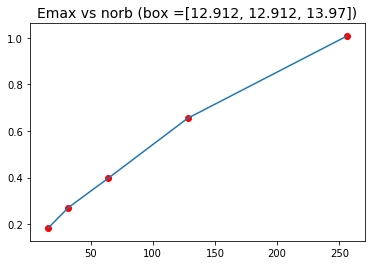

In [29]:
plt.plot(N,E)
plt.scatter(N,E, color='r')
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()

### Expansion of the perturbed KS orbitals

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e-2$ both in the $z$ and $x$ directions. The orbitals of the perturbed system have been computed for rmult = [9.0 , 9.0]

In [30]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [9.0, 9.0],
         'gnrm_cv' :1e-8,
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 0,
         'itermax_virt' : 1},
        'radical': 'N2_rmult9', #always in the same directory
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,inputpath + 'default.yaml')

We don't write the resulting wf on the disk and set itermax_virt : 1, in this way the simulation only perform the scalar product of the states given as input with the perturbed wf

In [31]:
n = 256
Ex_psip = '../data-Ex_1em2_rmult_9/'
Ez_psip = '../data-Ez_1em2_rmult_9/'
inpEx={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ex_psip}}
inpEz={'dft':{'norbv': -n},'tddft':{'decompose_perturbation': Ez_psip}}
ExInpname = 'N2Ex_rmult9_norb'+str(n)
EzInpname = 'N2Ez_rmult9_norb'+str(n)

Yaml.dump(inpEz,inputpath + EzInpname + '.yaml')
Yaml.dump(inpEx,inputpath + ExInpname + '.yaml')

Now we import the result and perform the data analysis

In [32]:
logs = !ls testfiles/N2maxEngVorb/log/log-N2E*_rmult9_norb256.yaml
print(logs)
N2data=[lf.Logfile(l) for l in logs]

['testfiles/N2maxEngVorb/log/log-N2Ex_rmult9_norb256.yaml', 'testfiles/N2maxEngVorb/log/log-N2Ez_rmult9_norb256.yaml']


We define the  following list of arrays (the first element correponds to Ex, the second to Ez): 

In [33]:
coeff_occ = [n.log['<psi_i|psi_j>'] for n in N2data]
coeff_occ=np.double(np.array(coeff_occ))

coeff_vrt = [n.log['<psiv_i|D psi_j>'] for n in N2data]
coeff_vrt=np.double(np.array(coeff_vrt))

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

We also read other useful quantities (we define common quantities for both Ex and Ez since the orbitals are the same)

In [34]:
n_occ,n_vrt = coeff_vrt[0].shape
print 'no_occ',n_occ, 'n_vrt', n_vrt
en = N2data[0].evals[0][0]
e_v=[]
e_o=[]
for o in range(n_occ):
    e_o.append(en[o])
for v in range(n_occ,n_occ+n_vrt):
    e_v.append(en[v])


no_occ 5 n_vrt 256


In [35]:
# we compute the norm of the perturbed orbitals projected on the basis of the occupied states
psiprimeEx=np.array([ 0.0 for i in range(n_occ)])
psiprimeEz=np.array([ 0.0 for i in range(n_occ)])
for o in range(n_occ):
    psiprimeEx += coeff_occ[0][o]**2
    psiprimeEz += coeff_occ[1][o]**2
# we quantify the magnitude of the missing part
psiprimeEx = 1.0-psiprimeEx
psiprimeEz = 1.0-psiprimeEz
print 'psiprimeEx Norm ',np.sqrt(psiprimeEx)
print 'psiprimeEz Norm ',np.sqrt(psiprimeEz)
# and we find the maximum value
referenceEx=np.max(psiprimeEx)
referenceEz=np.max(psiprimeEz)
# we add the contribution of the empty orbitals
crEx=[[] for p in range(n_occ)]
crEz=[[] for p in range(n_occ)]
for p in range(n_occ):
    for v in range(n_vrt):
      psiprimeEx[p] -= coeff_vrt[0][p][v]**2
      psiprimeEz[p] -= coeff_vrt[1][p][v]**2    
      crEx[p].append(psiprimeEx[p]/referenceEx)
      crEz[p].append(psiprimeEz[p]/referenceEz)

psiprimeEx Norm  [ 0.00126599  0.01044813  0.01163324  0.00656826  0.00913968]
psiprimeEz Norm  [ 0.00110997  0.00760269  0.01161194  0.01161194  0.01434794]


In [36]:
#to display the plot in a separate window
#%matplotlib auto
#to display back in the nb
#%matplotlib inline 

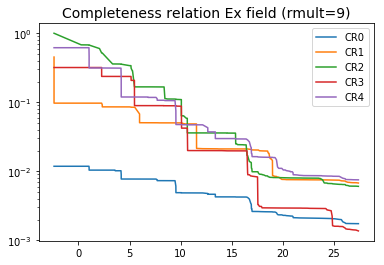

In [37]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEx[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ex field (rmult=9)', fontsize=14)
plt.show()

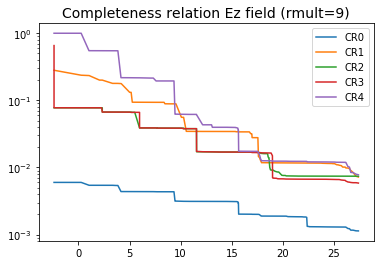

In [38]:
for p in range(n_occ):
    plt.semilogy(27.211*np.array(e_v),crEz[p],'-',label='CR'+str(p))
plt.legend()
plt.title('Completeness relation Ez field (rmult=9)', fontsize=14)
plt.show()